# Categories vs Dimensions Analysis
Is knowledge about social relationships conceptually organized as categories or dimensions?

Representational similarity analysis (RSA) will be used to explore this question. Representational dissimilarity matrices (RDMs) will be created for the dimensional and categorical tasks for each participant. These will be the unit of comparison for each participant.

In [5]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask
from nltools.stats import fdr, threshold, fisher_r_to_z, one_sample_permutation
from sklearn.metrics import pairwise_distances
from nilearn.plotting import plot_glass_brain, plot_stat_map

from scipy.io import loadmat
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

from sklearn import manifold
import scipy.stats as stats


# Dimensions Analysis
To capture the dimensional organization of social relationships, we will consider how participants organize relationships in a "free-arrangement" task. In this task, participants were asked to organize 159 social relationships in a circular area, based on their own perceived similarites of the relationships.

The difference between relationships will be captured as the distance between the relationships placement within the circle. Therefore, we will have a continuous measure of the difference (or similarity) between relationships.

dissimilarity = Euclidean distance between relationships, after multi-dimensional scaling (MDS) was completed

### Data import and prep
Distances were automatically calculated by the task software (distance from MDS). The output of the data is a 1-D array with dissimilarities between each of the relationships. This 1-D array will be converted into a 2-D dissimilarity matrix, for each subject.

In [6]:
work_dir = '/Volumes/GoogleDrive/My Drive/categories_dimensions/subject_data'
os.chdir(work_dir)

In [7]:
#Import files
mat_subj = []
for file in glob.glob('*.mat'):
    mat_subj.append(file)

    
mat = loadmat(mat_subj[0])

#Delete excess spacing for relationship values
relationships=[]
for i in mat['stimuli']:
    delete_spaces = i.replace('  ','')
    delete_spaces = delete_spaces.strip()
    relationships.append(delete_spaces)
    
r1 = relationships

#Create a table with socID and corresponding meadowsID to be matched in RDM output name
soc_id = pd.read_csv('/Volumes/GoogleDrive/My Drive/categories_dimensions/soc_meadows.csv')
soc_meadows = soc_id.drop(['Unnamed: 0'], axis = 1)

#Drop bad subjects (details below in Bad Subjects cell)
soc_meadows.drop(soc_meadows.index[51:], inplace = True)
soc_meadows.drop(soc_meadows.index[47], inplace=True)
soc_meadows.drop(soc_meadows.index[28], inplace=True)
soc_meadows.drop(soc_meadows.index[1], inplace=True)
soc_meadows.drop(soc_meadows.index[27], inplace=True)
soc_meadows.drop(soc_meadows.index[14], inplace=True)

#Add new column with both items for later RSA analysis 
soc_meadows["subj_id"] = soc_meadows["meadows_id"]
subj_id = soc_meadows['subj_id']
#soc_meadows['subj_id'] = '"' + soc_meadows['subj_id'].astype(str) + '"'
subj_id


0     divine-pigeon
2       ready-sloth
3      whole-mantis
4         meet-mule
5     enough-falcon
6       more-ferret
7       neat-marten
8          keen-hen
9         moral-cub
10     awake-gannet
11     exact-toucan
12         in-horse
13    secure-osprey
14       valued-ape
16       upward-kid
17     tough-jennet
18     noted-salmon
19      heroic-crab
20      ready-squid
21       funny-buck
22       handy-moth
23       pet-beetle
24        equal-bug
25    stable-minnow
26      comic-viper
27        calm-dove
30         solid-ox
31      amazed-dodo
32       finer-oryx
33    modern-monkey
34      holy-grouse
35      alert-wahoo
36     subtle-perch
37     expert-coral
38       smart-clam
39        key-eagle
40      close-burro
41       brave-moth
42     giving-racer
43      better-kite
44         fast-ant
45      intent-gull
46     unique-tapir
48         just-kit
49       vast-bunny
50       sure-adder
Name: subj_id, dtype: object

## Create RDM

In [30]:
dissim = pd.DataFrame(squareform(mat['rdmutv'][0]), columns=relationships, index=relationships)
count = 1
dissim_dict = {}
for subj in mat_subj:
    temp = pd.DataFrame(squareform(mat['rdmutv'][0]), columns=relationships, index=relationships)
    dissim = dissim + temp
    meadows_list = []
    meadows_id = subj.split('_')[6]
    meadows_list.append(meadows_id)
    meadows_list = pd.DataFrame(meadows_list)    
    meadows_list.columns = ['meadows_id']
    meadows_list.set_index('meadows_id', inplace=True)
    merged_df = meadows_list.merge(soc_meadows, how = 'inner', on = ['meadows_id', 'meadows_id'])
    dissim_dict[meadows_id] = dissim
    #The code below can be uncommented to save each dataframe as a file into folder 
    #work_dir3 = '/Volumes/GoogleDrive/My Drive/categories_dimensions/subject_data/Subject_Category_RDMs'
    #os.chdir(work_dir3)
    #dissim.to_csv('Subject_MA_RDMs/{}.csv'.format((merged_df['meadows_id'][0]+'_'+merged_df['soc_id'][0])), sep=',')
    
dissim = dissim.apply(pd.to_numeric)
dissim = dissim.div(len(mat_subj))

#dissim.head()
#dissim.max()


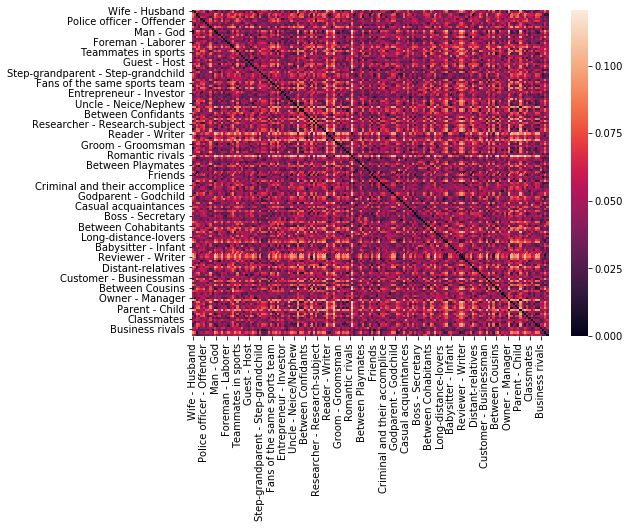

In [48]:
#Heatmap visualization for example subject's free-arrangement RDM 
fig, ax = plt.subplots(figsize=(8,6))
dim_heatmap = sns.heatmap(dissim_dict['whole-mantis'], ax=ax)


# Category Analysis
To capture the categorical orgnization of social relationships, we will consider how participants organize relationships into discrete categories. In this task, participants were asked to organize 159 social relationships into categories of their choosing. They could make up to 8 categories, and could name them anything they wanted. Participants were also able to place a single relationship into multiple categories. 

The difference between relationships will be calculate based on whether relationships were in the same category or not. A dissimilarity matrix will be created, where relationships which were in the same category, will have a value of "0" for that respective cell in the matrix, while relationships which were in different categories, will have a "1" for that respective cell. 

dissimilarity = same (0) or different (1) categories

### Data import and prep

In [11]:
#Import
subjects_data = []
for file in glob.glob("*.csv"):
    subjects_data.append(file) 

## Remove outliers and bad participants
Remove participants who made too few categories or that did not do that task correctly.

Too few is defined as ....

Currently, too few categories is less than 5.4. This analysis can be seen in the "Categoy Outliers" notebook. Participants with a mean RDM average score of less than 0.2 were also excluded. Their files were copied into an "outliers" folder and removed from the "subj_id" list in cell 6 so they are not included in the RSA analysis. I did not cut them from the main analysis so that we can still seem them in the overall "subjects RDM," but they could be removed using .drop(). That code is in the cell but commented out. 

Category outlier: 
- 'intent-gull' has been removed from the subj_id table

Average category RDM correlation less than 0.2:
- 'calm-dove', 'amazed-cub', 'valued-ape' have been removed from the subj_id table
- can see data for this under cell "Create RDM for all subjects"

Reminder: subject numbers are saved next to soc and meadows IDs in folder

## Creating category RDMs

In [12]:
rdm_r1 = pd.DataFrame(columns=relationships)
meadows_list = []
count = 1
dict_rdms = {}
for subject in subjects_data:
    csv_subj = pd.read_csv(subject).iloc[:, 1:]
    rdm_r1 = pd.DataFrame(columns=relationships)
    for r1_a in relationships:
        cols = [] 
        for col in csv_subj.columns:
            if r1_a in csv_subj[col].tolist():
                cols.append(col)
        for r1_b in relationships:
            if not cols:
                rdm_r1.loc[r1_a,r1_b] = 1
            elif csv_subj[cols].isin([r1_b]).any()[0]:
                rdm_r1.loc[r1_a,r1_b] = 0
            else:
                rdm_r1.loc[r1_a,r1_b] = 1
    meadows_list = []
    meadows_id = subject.split('_')[6]
    meadows_list.append(meadows_id)
    meadows_list = pd.DataFrame(meadows_list)    
    meadows_list.columns = ['meadows_id']
    meadows_list.set_index('meadows_id', inplace=True)
    merged_df = meadows_list.merge(soc_meadows, how = 'inner', on = ['meadows_id', 'meadows_id'])
    dict_rdms[meadows_id] = rdm_r1
    count=count+1
    #The code below can be uncommented to save each dataframe as a file into folder 
    #work_dir3 = '/Volumes/GoogleDrive/My Drive/categories_dimensions/subject_data/Subject_Category_RDMs'
    #os.chdir(work_dir3)
    #rdm_r1.to_csv('Subject_Category_RDMs/{}.csv'.format((merged_df['meadows_id'][0]+'_'+merged_df['soc_id'][0])), sep=',')
    #print('next')
                  

#Access a specific RDM by printing d[*insert 'meadows_id' here*]

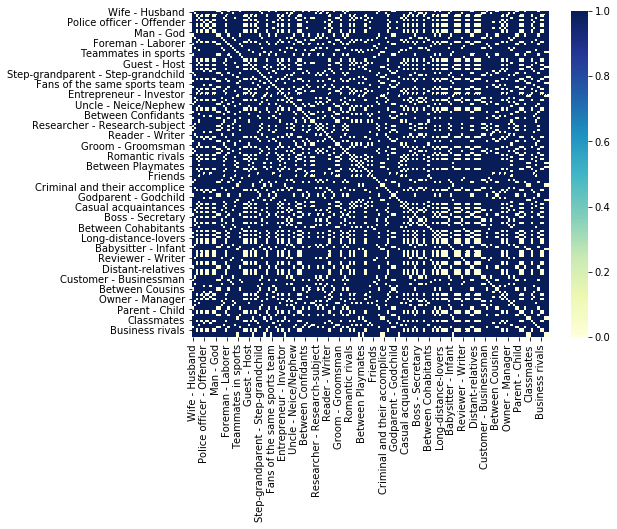

In [49]:
#Heatmap visualization for example subject's category RDM 
fig, ax = plt.subplots(figsize=(8,6))
cat_heatmap = sns.heatmap(dict_rdms['whole-mantis'], ax=ax, cmap="YlGnBu")

## Create RDM for all subjects 

In [52]:
subject_flat_arrays = []
subjects_rdm = pd.DataFrame(columns=dict_rdms.keys())
for subj_a in dict_rdms.keys():
    subj_a_flat = dict_rdms[subj_a].values.flatten()
    subject_flat_arrays.append(subj_a_flat)
    for subj_b in dict_rdms.keys():
        subj_b_flat = dict_rdms[subj_b].values.flatten()
        subjects_rdm.loc[subj_a,subj_b] = np.corrcoef(subj_a_flat, subj_b_flat)[0][1]

In [53]:
subjects_rdm
subjects_rdm.mean(axis = 0) 
#subjects_rdm.drop(['calm-dove', 'amazed-cub', 'valued-ape', 'intent-gull'], axis = 0)
#subjects_rdm.drop(['calm-dove', 'amazed-cub', 'valued-ape', 'intent-gull'], axis = 1)


divine-pigeon    0.261668
ready-sloth      0.260982
amazed-cub       0.182768
meet-mule        0.349988
whole-mantis     0.276384
enough-falcon    0.287302
more-ferret      0.304843
neat-marten      0.315321
keen-hen         0.288915
moral-cub        0.252986
awake-gannet     0.342247
exact-toucan     0.294590
in-horse         0.346787
secure-osprey    0.247811
valued-ape       0.168967
great-midge      0.244604
upward-kid       0.279212
tough-jennet     0.304878
noted-salmon     0.307157
heroic-crab      0.341855
ready-squid      0.208244
funny-buck       0.252461
pet-beetle       0.297669
equal-bug        0.314128
stable-minnow    0.293167
calm-dove        0.162963
comic-viper      0.287401
solid-ox         0.305257
amazed-dodo      0.297608
finer-oryx       0.267815
moral-grouse     0.208158
alert-wahoo      0.359561
expert-coral     0.304675
subtle-perch     0.213705
handy-moth       0.353446
modern-monkey    0.262122
smart-clam       0.336210
holy-grouse      0.233154
key-eagle   

# RSA - Category and Dimensional similarity
First, we will correlate each subject's categorical RDM and dimensional RDM.

cat = category
mla = multi-arrangement (free arrangment). We should probably use free arrangement as the name for now on

In [54]:
#Make conditions variable from names 
conditions = []
for col in dict_rdms["whole-mantis"]:
    conditions.append(col)
conditions

['Wife - Husband',
 'Nurse - Patient',
 'Officer - Soldier',
 'Neighbors',
 'Athletic trainer - Trainee',
 'Police officer - Offender',
 'Principal - Teacher',
 'Doctor - Nurse',
 'Victim - Criminal',
 'Coach - Athlete',
 'Man - God',
 'Between Half-siblings',
 'Parent - Teenager',
 'Prostitute - Customer',
 'Church members',
 'Foreman - Laborer',
 'Person - Family friends',
 'Person - their Social media follower',
 'Guide - Tourist',
 'Bride - Bridesmaid',
 'Teammates in sports',
 'Between Twins',
 'Celebrity - Haters',
 'Employer - Employee',
 'Teacher - Student',
 'Guest - Host',
 "Man's Wife - Man's Mistress",
 'Religious followers',
 'Intern - Employee',
 'Criminal - Police officer',
 'Step-grandparent - Step-grandchild',
 'Chef - Customer',
 'Union-leader - Union-member',
 'Professor - Graduate student',
 'Between Second-cousins',
 'Fans of the same sports team',
 'Master - Servant',
 'Between Siblings',
 'Landlord - Housekeeper',
 'Close-friends',
 'Entrepreneur - Investor',
 'F

In [55]:
all_sub_cat_mla_rsa = {}
for subj in subj_id[1:]:
    
    #Variable containing category RDMs
    subj_cat_rdm = dict_rdms[subj]
    
    #Make adjacency matrix for category RDMs
    subj_cat_adj = Adjacency(subj_cat_rdm[conditions].loc[conditions], matrix_type='distance', labels=conditions)
    
    #Variable containing free arrangement RDMs
    subj_mla_rdm = dissim_dict[subj]
    
    #Make adjacency matrix for free-arrangement RDMs 
    subj_mla_adj = Adjacency(subj_mla_rdm[conditions].loc[conditions], matrix_type='distance', labels=conditions)
    
    #Compare category to free arrangement 
    comp_cat_mla = subj_mla_adj.similarity(subj_cat_adj, metric='spearman', n_permute=0) 
    
    #Put comparisons into new dictionary 
    all_sub_cat_mla_rsa[subj] = comp_cat_mla['correlation']

all_sub_cat_mla_rsa = pd.DataFrame(all_sub_cat_mla_rsa, index=['r', 'p']).T
all_sub_cat_mla_rsa

,r,p
ready-sloth,0.094147,0.094147
whole-mantis,0.089465,0.089465
meet-mule,0.106183,0.106183
enough-falcon,0.103736,0.103736
more-ferret,0.065681,0.065681
neat-marten,0.071859,0.071859
keen-hen,0.074608,0.074608
moral-cub,0.093034,0.093034
awake-gannet,0.107677,0.107677
exact-toucan,0.132819,0.132819


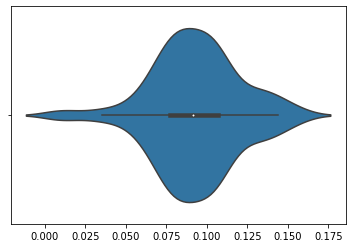

In [57]:
cat_mla_corr_plot = sns.violinplot(all_sub_cat_mla_rsa)

# Categories vs Dimensions
In this analysis, we will see if there is higher inter-subject reliability with the categorization task, or with the free arrangement task.

In [61]:
#tau_subj = {}
#for key in subj_id[1:]:
    #tau, p_value = stats.kendalltau(dissim_dict[key], dict_rdms[key])
    #tau_subj[key] = tau, p_value


In [62]:
#tau_subj['whole-mantis']

(0.08984990214076997, 1.5506923853880914e-68)

In [58]:
#for key in dissim_dict:
    #for i in dissim_dict: 
        #tau, p_value = stats.kendalltau(dissim_dict[key], dissim_dict[i])
        

In [59]:
#for key in dict_rdms:
        #tau, p_value = stats.kendalltau(dict_rdms[key], dict_rdms[key])

In [60]:
#tau, p_value